# Option-Implied Probability  
This script is inspired by https://reasonabledeviations.com/2020/10/01/option-implied-pdfs/

In [21]:
#import nasdaqdatalink
#raw_sb = nasdaqdatalink.get("CHRIS/CME_BO1")

# Downloaded from: https://www.barchart.com/futures/quotes/ZL*0/options?moneyness=20
import pandas as pd
raw_sbo = pd.read_csv('zlf23-options-american-options-exp-12_23_22-20-strikes-intraday-11-25-2022.csv')
raw_sbo.head(10)

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,Last Trade
0,67.500C,5.545,5.545,5.545,0.570,5.380,5.500,NaN,74.0,3327,11/23/22
1,67.500P,0.980,0.860,0.860,-0.185,0.775,0.795,24.0,124.0,516,11/23/22
2,68.000C,5.170,5.170,5.170,0.555,4.990,5.115,NaN,84.0,3102,11/23/22
3,68.000P,1.300,0.980,0.980,-0.205,0.890,0.910,832.0,1938.0,588,11/23/22
4,68.500C,4.805,4.805,4.805,0.530,4.630,4.740,NaN,33.0,2883,11/23/22
5,68.500P,1.260,1.115,1.115,-0.225,1.020,1.040,41.0,157.0,669,11/23/22
6,69.000C,4.450,3.695,4.450,0.505,4.280,4.375,1.0,211.0,2670,11/23/22
7,69.000P,1.105,1.105,1.105,-0.155,1.160,1.185,194.0,1063.0,663,08:51 CT
8,69.500C,4.275,4.275,4.275,0.160,3.965,4.015,10.0,112.0,2565,08:52 CT
9,69.500P,1.385,1.265,1.265,-0.155,1.320,1.345,25.0,475.0,759,08:52 CT


In [22]:
# Assign Types, Normalize DF (Separate Columns)
def clean_options(df):
    # Fix Types
    import numpy as np
    df = df.replace(np.nan,0)
    df.Volume = df.Volume.astype(int)
    df['Open Int'] = df['Open Int'].astype(int)

    # Separate Columns
    df['Strike Price'] = df.Strike.str.extract('(\d+\.\d+)').astype(float)
    df['Type'] = df.Strike.str[-1]
    df.Type = df.Type.replace({'C': 'Call', 'P': 'Put'})
    df = df.drop(['Strike'], axis=1)

    # Fix Date
    df['Last Trade'] = df['Last Trade'].str.replace('CT', '', regex=True)
    df['Last Trade'] = pd.to_datetime(df['Last Trade']).dt.tz_localize('America/Chicago')

    return df[['Last Trade','Strike Price','Type','Last','Volume','Open Int','Premium']]

sbo = clean_options(raw_sbo)
sbo.head(10)

,Last Trade,Strike Price,Type,Last,Volume,Open Int,Premium
0,2022-11-23 00:00:00-06:00,67.5,Call,5.545,0,74,3327
1,2022-11-23 00:00:00-06:00,67.5,Put,0.860,24,124,516
2,2022-11-23 00:00:00-06:00,68.0,Call,5.170,0,84,3102
3,2022-11-23 00:00:00-06:00,68.0,Put,0.980,832,1938,588
4,2022-11-23 00:00:00-06:00,68.5,Call,4.805,0,33,2883
5,2022-11-23 00:00:00-06:00,68.5,Put,1.115,41,157,669
6,2022-11-23 00:00:00-06:00,69.0,Call,4.450,1,211,2670
7,2022-12-02 08:51:00-06:00,69.0,Put,1.105,194,1063,663
8,2022-12-02 08:52:00-06:00,69.5,Call,4.275,10,112,2565
9,2022-12-02 08:52:00-06:00,69.5,Put,1.265,25,475,759


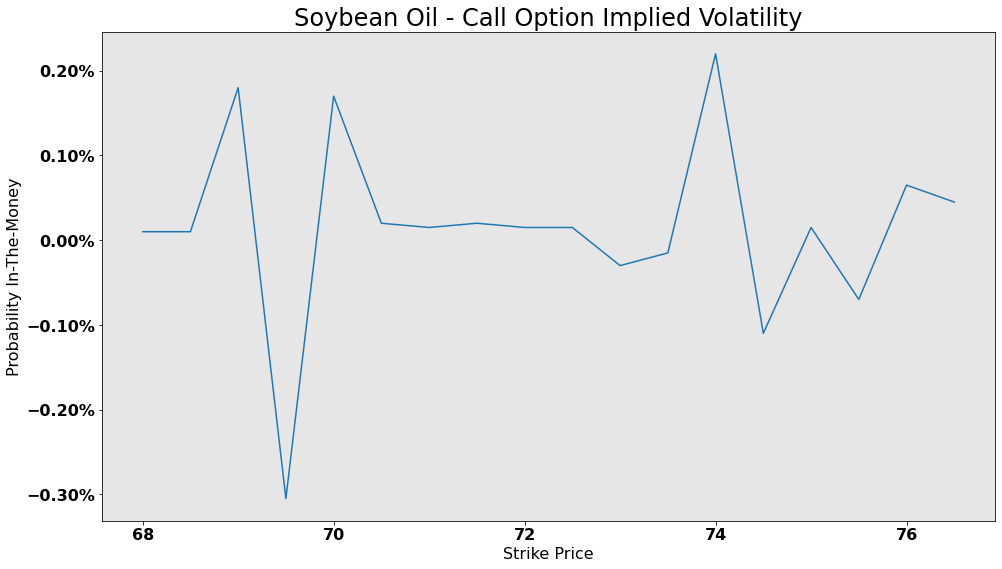

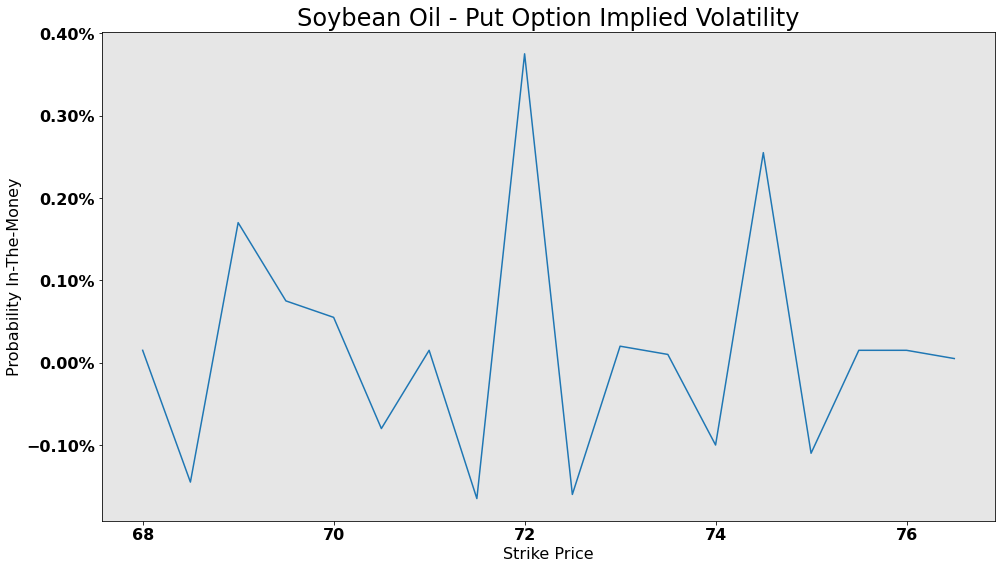

In [31]:
# Calculate probabilities from strike and price, then visualize p
def get_probs(df, strikes_name, prices_name, commodity):

    def visualize_pdf(strikes, probs):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'figure.figsize': (16,9)})

        fig, ax = plt.subplots(figsize=(16,9))
        ax.plot(strikes, probs)
        ax.set_title(f'{commodity} - {t} Option Implied Volatility',fontsize = 24)
        ax.set_xlabel('Strike Price')
        ax.set_ylabel('Probability In-The-Money')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_facecolor('#E6E6E6')
        plt.show()

    # Calculate probabilities and visualize PDF for Call and Put options
    for t in df.Type.unique():
        dfo=df[df.Type == t]
        strikes=dfo[strikes_name]
        prices=dfo[prices_name]

        # Window the df to have one strike per row, but the 3 prices near it for each butterfly
        import numpy as np
        strike, l_price, m_price, u_price = [], [], [], []
        for i in np.arange(0,len(strikes)):
            if (i>0) & (i<len(strikes)-1):
                l_price.append(prices.iloc[i-1])
                strike.append(strikes.iloc[i])
                m_price.append(prices.iloc[i])
                u_price.append(prices.iloc[i+1])
    
        # For each strike price, calculate the probability, p
        s, p = [], []
        for i in np.arange(0,len(strike)):
            sp = strike[i]
            lp = l_price[i]
            mp = m_price[i]
            up = u_price[i]

            # Calculate the probability a future expires at the target price
            prob = lp - (2 * mp) + up
            s.append(sp)
            p.append(prob)
        visualize_pdf(s,p)

        probs = pd.DataFrame({'Strike Price': s,'Probability':p})
        probs=probs.dropna(axis=0)

        if t=='Call':
            c_probs = probs
        elif t=='Put':
            p_probs = probs
    return(c_probs, p_probs)

# Filter Call Strikes and Prices
c_sbo, p_sbo = get_probs(sbo, 'Strike Price', 'Last', 'Soybean Oil')

In [32]:
# Merge data [optional]
c_sbo['Type']='Call'
p_sbo['Type']='Put'
sbo_probs = pd.concat([c_sbo,p_sbo], ignore_index=True)
sbo_probs

,Strike Price,Probability,Type
0,68.0,0.010,Call
1,68.5,0.010,Call
2,69.0,0.180,Call
3,69.5,-0.305,Call
4,70.0,0.170,Call
5,70.5,0.020,Call
6,71.0,0.015,Call
7,71.5,0.020,Call
8,72.0,0.015,Call
9,72.5,0.015,Call


In [ ]:
# Remove Outliers


In [6]:
# Fit cubic spline, a gaussian distribution fit on the probabilities of each target strike price
df=c_sbo.copy()
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
#cs = CubicSpline(x, y)
cs = CubicSpline(c_sbo['Strike Prices'], c_sbo['Last'], bc_type='natural')
print(cs.c)




fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(c_sbo['Strike Prices'], c_sbo['Last'], 'o', label='data')
ax.plot(xs, np.sin(xs), label='true')
ax.plot(xs, cs(xs), label="S")
plt.show()


In [ ]:
def get_pdf(df):
    return (df)